In [1]:
import pandas as pd
from pathlib import Path

In [2]:
data_dir = Path("../data/unhealthy")
full_dataset = data_dir / "unhealthy_full.csv"
train_original = data_dir / "aggregated/train.csv"
val_original = data_dir / "aggregated/val.csv"
test_original = data_dir / "aggregated/test.csv"

train_final_path = data_dir / "train.csv"
val_final_path = data_dir / "val.csv"
test_final_path = data_dir / "test.csv"

In [3]:
full_df = pd.read_csv(full_dataset)
train_or_df = pd.read_csv(train_original)
val_or_df = pd.read_csv(val_original)
test_or_df = pd.read_csv(test_original)
full_df.shape, full_df.columns, train_or_df.columns, full_df["_unit_id"].unique().shape

((227975, 12),
 Index(['_unit_id', 'comment', '_trust', '_worker_id', 'antagonize',
        'condescending', 'dismissive', 'generalisation',
        'generalisation_unfair', 'healthy', 'hostile', 'sarcastic'],
       dtype='object'),
 Index(['_unit_id', '_trusted_judgments', 'comment', 'antagonize',
        'antagonize:confidence', 'condescending', 'condescending:confidence',
        'dismissive', 'dismissive:confidence', 'generalisation',
        'generalisation:confidence', 'generalisation_unfair',
        'generalisation_unfair:confidence', 'healthy', 'healthy:confidence',
        'hostile', 'hostile:confidence', 'sarcastic', 'sarcastic:confidence'],
       dtype='object'),
 (48909,))

In [4]:
train_or_df.shape[0], val_or_df.shape[0], test_or_df.shape[0], train_or_df.shape[0] + val_or_df.shape[0] + test_or_df.shape[0]

(35503, 4427, 4425, 44355)

In [5]:
full_df.drop_duplicates(subset=["comment"]).shape

(44355, 12)

In [6]:
datasets = [train_or_df, val_or_df, test_or_df]
t1 = datasets[0].drop_duplicates(subset=["comment"])
v1 = datasets[1].drop_duplicates(subset=["comment"])
d1 = datasets[2].drop_duplicates(subset=["comment"])
print(t1.shape[0], v1.shape[0], d1.shape[0])
print(t1.shape[0] + v1.shape[0] + d1.shape[0])
f = pd.concat([t1, v1, d1], axis=0)
print(f.shape[0])
print(f.drop_duplicates(subset=["comment"]).shape[0])

35503 4427 4425
44355
44355
44355


In [7]:
def clean_empty_annotations(df):
    
    label_columns = sorted([
        "antagonize", "condescending" , "dismissive", "generalisation",
        "generalisation_unfair", "healthy", "hostile", "sarcastic"
    ])
    def is_empty(sample):
        sum_ = sum([sample[label] for label in label_columns])
        empty = False
        if sum_ == 0:
            empty = True
        return empty

    df["empty"] = df.apply(is_empty, axis=1)
    df = df[~df["empty"]]
    return df.drop(columns=["empty"])
    

In [8]:
full_df = clean_empty_annotations(full_df)
full_df.shape

(215265, 12)

In [9]:
train_texts = train_or_df["comment"]
test_texts = test_or_df["comment"]
val_texts = val_or_df["comment"]
new_train = full_df[full_df["comment"].isin(train_texts)]
new_test = full_df[full_df["comment"].isin(test_texts)]
new_val = full_df[full_df["comment"].isin(val_texts)]

new_train.shape, new_val.shape, new_test.shape

((172550, 12), (20893, 12), (21822, 12))

In [10]:
def check_users(train, test, dev):
    train_users = train["_worker_id"].unique()
    dev_users = dev["_worker_id"].unique()
    test_users = test["_worker_id"].unique()
    print("sizes -", "train:", train_users.shape, "val:", dev_users.shape, "test:", test_users.shape)
    train_dev = (len(set(train_users) - set(dev_users)), len(set(dev_users) - set(train_users)))
    train_test = (len(set(train_users) - set(test_users)), len(set(test_users) - set(train_users)))
    test_dev = (len(set(test_users) - set(dev_users)), len(set(dev_users) - set(test_users)))
    print(train_dev, train_test, test_dev)
    print(set(train_users) - set(test_users))

In [11]:
check_users(new_train, new_test, new_val)

sizes - train: (588,) val: (535,) test: (544,)
(53, 0) (44, 0) (34, 25)
{32004236, 44525709, 44917645, 44133779, 43863574, 28813722, 28521374, 44316447, 23583649, 45173668, 44660135, 44621224, 44373931, 45312428, 44642735, 45288496, 44641336, 39942073, 44183354, 44576955, 44009147, 44879933, 44624320, 44636227, 45212102, 43861190, 44064968, 45175505, 44638804, 44941271, 45304921, 44608861, 45230560, 44559586, 44584806, 44599399, 44682089, 45009900, 44685039, 44636401, 44114418, 44546678, 6713206, 44554623}


In [12]:
def clean_users(new_train, new_val, new_test):
    in_test = new_train[new_train["_worker_id"].isin(new_test["_worker_id"])]
    in_both = in_test[in_test["_worker_id"].isin(new_val["_worker_id"])]
    dev_both = new_val[new_val["_worker_id"].isin(in_both["_worker_id"])]
    test_both = new_test[new_test["_worker_id"].isin(in_both["_worker_id"])]
    print(in_both.shape, dev_both.shape, test_both.shape)
    return in_both, dev_both, test_both

In [13]:
in_both, dev_both, test_both = clean_users(new_train, new_val, new_test)

(171873, 12) (20847, 12) (21765, 12)


In [14]:
check_users(in_both, test_both, dev_both)

sizes - train: (510,) val: (510,) test: (510,)
(0, 0) (0, 0) (0, 0)
set()


In [21]:
def average_annotation_per_user(df, crop=False):
    annotation_number = df.groupby(by=["_worker_id"]).count()["comment"].sort_values()
    print("annotator head")
    print(annotation_number.head())
    print("annotator tail")
    print(annotation_number.tail())
    mean = annotation_number.mean()
    max = annotation_number.max()
    min = annotation_number.min()
    median = annotation_number.median()
    (annotation_number/max).reset_index()["comment"].plot()
    all = df.shape[0]
    upper_threshold = 0.6*max
    lower_threshold = 0.01*max
    print("ANNOTATORS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)
    text_number = df.groupby(by=["comment"]).count()["_worker_id"].sort_values()
    print("text head")
    print(text_number.head())
    print("text tail")
    print(text_number.tail())
    mean = text_number.mean()
    max = text_number.max()
    min = text_number.min()
    median = text_number.median()
    (text_number/max).reset_index()["_worker_id"].plot()
    all = df.shape[0]
    print("TEXTS")
    print("min:", min, "mean:", mean, "median:", median ,"max:", max, "all:", all)    
    curr_df = df
    if crop:
        print("cropping...")
        print(curr_df.shape)
        to_crop = []
        for worker in df["_worker_id"].unique():
            if annotation_number[worker] < lower_threshold:
                curr_df = curr_df[curr_df["_worker_id"] != worker]
            if annotation_number[worker] > upper_threshold:
                to_crop.append(worker)
        print("after lower crop, before upper")
        print(curr_df.shape)
        for worker in to_crop:
            crop_number = int(annotation_number[worker] - upper_threshold)
            ann_to_drop = curr_df[curr_df["_worker_id"] == worker].sample(n=crop_number)
            anns = pd.merge(curr_df, ann_to_drop, how="outer", indicator=True)
            curr_df = anns[anns["_merge"] == "left_only"].drop(columns=["_merge"], axis=1)
        print("cropping finished...")
        print(curr_df.shape)
    return curr_df.dropna()

In [22]:
def change_id_to_int(df):
    df["_worker_id"] = df["_worker_id"].astype(int)
    return df

In [23]:
def analyze_annotations(train, dev, test, crop=False):
    print('-'*10, 'check', "-"*10)
    check_users(train, test, dev)
    print('-'*10, 'clean', "-"*10)
    in_both, dev_both, test_both = clean_users(train, dev, test)
    print('-'*10, 'train', "-"*10)
    crop_train = average_annotation_per_user(in_both, crop=crop)
    print('-'*10, 'dev', "-"*10)
    crop_dev = average_annotation_per_user(dev_both, crop=crop)
    print('-'*10, 'test', "-"*10)
    crop_test = average_annotation_per_user(test_both, crop=crop)
    print('-'*10, 'check 2', "-"*10)
    check_users(crop_train, crop_test, crop_dev)
    print('-'*10, 'clean 2', "-"*10)
    train_final, dev_final, test_final = clean_users(crop_train, crop_dev, crop_test)
    print('-'*10, 'check 3', "-"*10)
    check_users(train_final, test_final, dev_final)
    train_final = change_id_to_int(train_final)
    dev_final = change_id_to_int(dev_final)
    test_final = change_id_to_int(test_final)
    return train_final, dev_final, test_final

---------- check ----------
sizes - train: (588,) val: (535,) test: (544,)
(53, 0) (44, 0) (34, 25)
{32004236, 44525709, 44917645, 44133779, 43863574, 28813722, 28521374, 44316447, 23583649, 45173668, 44660135, 44621224, 44373931, 45312428, 44642735, 45288496, 44641336, 39942073, 44183354, 44576955, 44009147, 44879933, 44624320, 44636227, 45212102, 43861190, 44064968, 45175505, 44638804, 44941271, 45304921, 44608861, 45230560, 44559586, 44584806, 44599399, 44682089, 45009900, 44685039, 44636401, 44114418, 44546678, 6713206, 44554623}
---------- clean ----------
(171873, 12) (20847, 12) (21765, 12)
---------- train ----------
annotator head
_worker_id
45284349    2
42260484    3
45308208    3
38025156    4
44156014    4
Name: comment, dtype: int64
annotator tail
_worker_id
44083576    1375
26024737    1583
33708599    1730
20512953    1938
20225558    2382
Name: comment, dtype: int64
ANNOTATORS
min: 2 mean: 336.956862745098 median: 199.0 max: 2382 all: 171873
text head
comment
Sheep is 

/tmp/ipykernel_2833952/3809983943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["_worker_id"] = df["_worker_id"].astype(int)
/tmp/ipykernel_2833952/3809983943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["_worker_id"] = df["_worker_id"].astype(int)


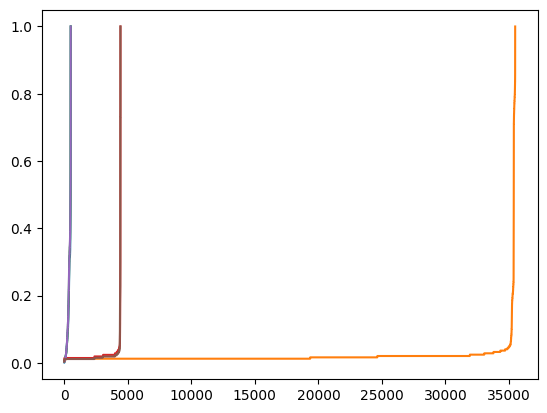

In [24]:
train_final, dev_final, test_final = analyze_annotations(new_train, new_val, new_test, crop=True)

---------- check ----------
sizes - train: (295,) val: (295,) test: (295,)
(0, 0) (0, 0) (0, 0)
set()
---------- clean ----------
(158678, 12) (19216, 12) (20112, 12)
---------- train ----------
head
_worker_id
45319598    126
45329986    131
45319546    135
45205782    136
45312438    138
Name: comment, dtype: int64
tail
_worker_id
44083576    1375
26024737    1430
33708599    1430
20512953    1430
20225558    1431
Name: comment, dtype: int64
min: 126 mean: 537.8915254237288 median: 474.0 max: 1431 all: 158678
---------- dev ----------
head
_worker_id
45250170    14
45319546    14
45277819    14
45252554    14
43754747    14
Name: comment, dtype: int64
tail
_worker_id
20225558    162
19638651    162
44083576    162
18960682    162
26024737    162
Name: comment, dtype: int64
min: 14 mean: 65.13898305084746 median: 58.0 max: 162 all: 19216
---------- test ----------
head
_worker_id
45312438    15
38399674    16
31410532    16
44649555    16
45252554    16
Name: comment, dtype: int64
tai

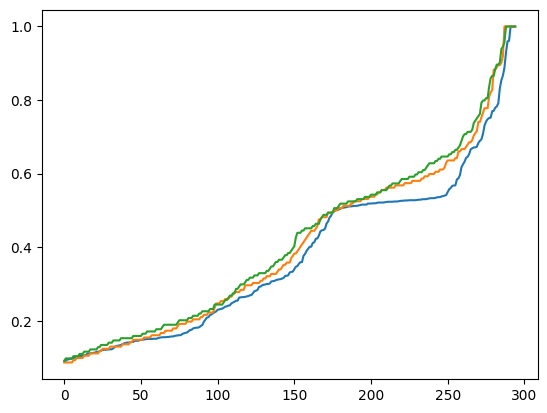

In [19]:
_ = analyze_annotations(train_final, dev_final, test_final, crop=False)

In [20]:
train_final.to_csv(train_final_path, index=False)
dev_final.to_csv(val_final_path, index=False)
test_final.to_csv(test_final_path, index=False)